| train_loss: 9.09e-02 | test_loss: 1.09e-01 | reg: 1.11e+01 | : 100%|█| 20/20 [00:10<00:00,  1.91it


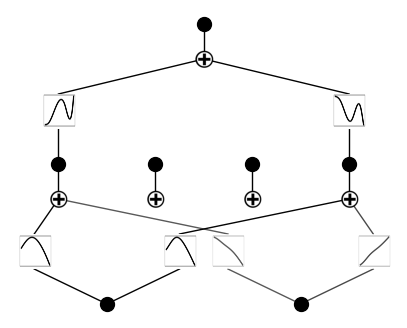

In [23]:
import torch
from kan import create_dataset
from kan.custom import MultKAN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

f = lambda x: torch.sin(2 * x[:, [0]]) * x[:, [1]]
dataset = create_dataset(f,
                         ranges=[-torch.pi, torch.pi],
                         n_var=2,
                         train_num=3000,
                         test_num=300,
                         device=device,
                         normalize_label=True,
                         normalize_input=True,
                         )

model = MultKAN(width=[2,4,1], grid=3, k=3, seed=0, device=device)
fit_kwargs = {'opt': 'LBFGS', 'lr': 1, 'lamb': 0.01,
              'lamb_entropy': 0.1, 'lamb_coef': 0.1, 'lamb_coefdiff': 0.5,}
model.fit(dataset, steps=20, **fit_kwargs)
model.plot()

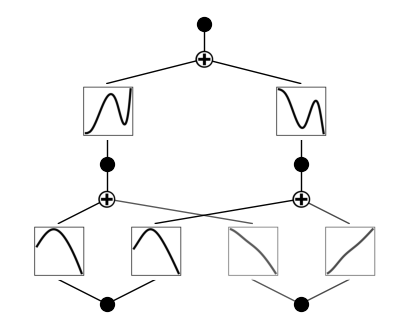

In [24]:
model = model.prune(edge_th=0.05, node_th=0.05)
model.plot()

In [25]:
grids = [3, 5, 10, 20, 30]

train_rmse = []
test_rmse = []

for i in range(len(grids)):
    model = model.refine(grids[i])
    results = model.fit(dataset, steps=50, stop_grid_update_step=20, **fit_kwargs)
    model = model.prune(edge_th=3e-2, node_th=1e-2)
    train_rmse.append(results['train_loss'][-1].item())
    test_rmse.append(results['test_loss'][-1].item())

| train_loss: 9.23e-02 | test_loss: 1.04e-01 | reg: 1.08e+01 | : 100%|█| 50/50 [00:27<00:00,  1.83it
| train_loss: 7.26e-02 | test_loss: 8.52e-02 | reg: 6.56e+00 | : 100%|█| 50/50 [00:20<00:00,  2.45it
| train_loss: 5.06e-02 | test_loss: 5.96e-02 | reg: 5.22e+00 | : 100%|█| 50/50 [00:26<00:00,  1.92it
| train_loss: 4.45e-02 | test_loss: 5.44e-02 | reg: 5.29e+00 | : 100%|█| 50/50 [00:15<00:00,  3.26it
| train_loss: 4.45e-02 | test_loss: 5.87e-02 | reg: 5.33e+00 | : 100%|█| 50/50 [00:28<00:00,  1.76it


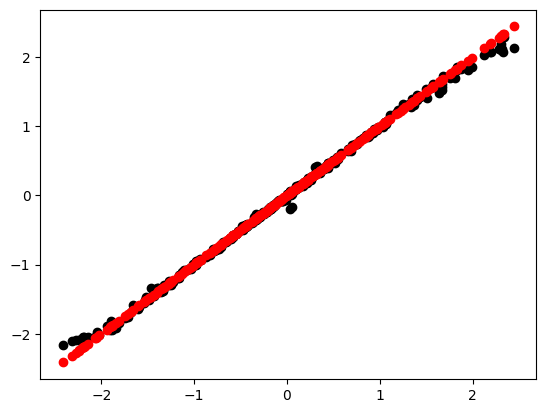

In [26]:
import matplotlib.pyplot as plt
y_pred = model(dataset['test_input']).detach().cpu().numpy()
plt.scatter(dataset['test_label'], y_pred, color='k')
plt.scatter(dataset['test_label'], dataset['test_label'], color='r')
plt.show()

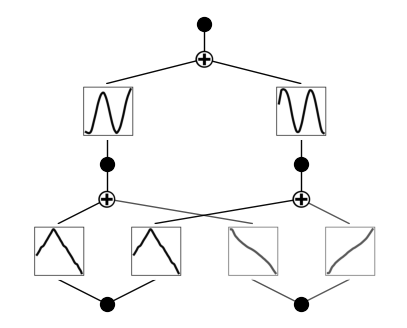

In [27]:
model.plot()

In [28]:
model.suggest_symbolic(0,1,0)

  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0        x    0.986069 -6.164549           1                1   -0.432910
1        0    0.000000  0.000014           0                0    0.000003
2    x^0.5    0.986795 -6.241700           2                2    0.351660
3     sqrt    0.986795 -6.241700           2                2    0.351660
4      log    0.986639 -6.224700           2                2    0.355060


('x',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  1,
  <function kan.utils.<lambda>(x, y_th)>),
 0.9860692620277405,
 1)

In [29]:
from kan.utils import ex_round
model.auto_symbolic()
# res = model.fit(dataset)
print(res['test_loss'][-1])
ex_round(model.symbolic_formula()[0][0], 4)

Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
fixing (0,0,0) with 0, r2=0.0, c=0
Best value at boundary.
r2 is 0.0
r2 is not very high, please double check if you are choosing the correct symbolic function.
fixing (0,0,1) with 0, r2=0.0, c=0
r2 is 0.9860692620277405
fixing (0,1,0) with x, r2=0.99, c=1
r2 is 0.989595890045166
fixing (0,1,1) with x, r2=0.99, c=1
r2 is 0.99905925989151
fixing (1,0,0) with cos, r2=1.0, c=2
r2 is 0.9968936443328857
fixing (1,1,0) with cos, r2=1.0, c=2
1.0886245


-1.0667*cos(0.7947*x_2 + 14.0218) - 1.0607*cos(0.7956*x_2 - 4.599) + 0.0194

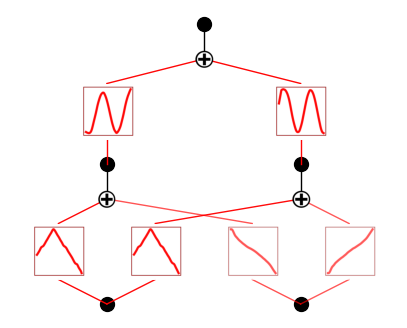

In [30]:
model.plot()

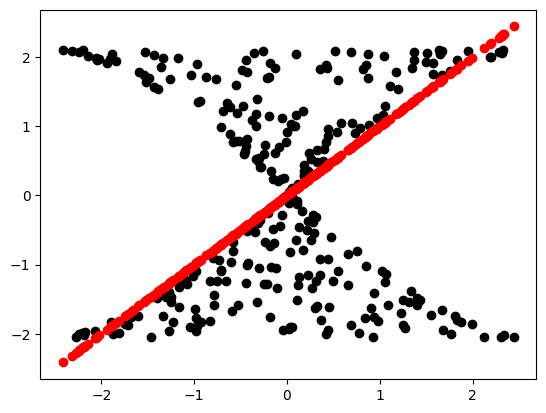

In [31]:
y_pred = model(dataset['test_input']).detach().cpu().numpy()
plt.scatter(dataset['test_label'], y_pred, color='k')
plt.scatter(dataset['test_label'], dataset['test_label'], color='r')
plt.show()